In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from joblib import dump, load
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.externals import joblib

E:\Anaconda\Software\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [3]:
new_file = 'newnew.xlsx'

In [4]:
new_dataframe = pd.read_excel(new_file, sheet_name=0)
new_dataframe1 = pd.read_excel(new_file, sheet_name=2).iloc[:, range(16)]
new_dataframe2 = pd.read_excel(new_file, sheet_name=2).iloc[:, range(17,31)]

In [5]:
# Dataset1
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
性别             158 non-null int64
年龄             158 non-null int64
吸烟             158 non-null int64
部位             158 non-null int64
原发灶大小          158 non-null int64
骨转移            158 non-null int64
脑转移            158 non-null int64
肝转             158 non-null int64
肺内转移           158 non-null int64
胸膜转移           158 non-null int64
治疗方案           158 non-null int64
疗效差0差1好/9个月    158 non-null int64
dtypes: int64(12)
memory usage: 14.9 KB


In [8]:
# Dataset2
new_dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 16 columns):
性别             158 non-null int64
年龄             158 non-null int64
吸烟             158 non-null int64
部位             158 non-null int64
原发灶大小          158 non-null int64
骨转移            158 non-null int64
脑转移            158 non-null int64
肝转             158 non-null int64
肺内转移           158 non-null int64
胸膜转移           158 non-null int64
治疗方案           158 non-null int64
突变情况123        158 non-null int64
TP53           158 non-null int64
rb1            158 non-null int64
pik3ca         158 non-null int64
疗效差1差2好/9个月    158 non-null int64
dtypes: int64(16)
memory usage: 19.9 KB


In [9]:
# Dataset3
new_dataframe2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 14 columns):
性别.1             158 non-null int64
年龄.1             158 non-null int64
吸烟.1             158 non-null int64
部位.1             158 non-null int64
原发灶大小.1          158 non-null int64
骨转移.1            158 non-null int64
脑转移.1            158 non-null int64
肝转.1             158 non-null int64
肺内转移.1           158 non-null int64
胸膜转移.1           158 non-null int64
治疗方案.1           158 non-null int64
突变情况123.1        158 non-null int64
N                158 non-null int64
疗效差1差2好/9个月.1    158 non-null int64
dtypes: int64(14)
memory usage: 17.4 KB


## Dataset for outside validation

In [10]:
## outside validation
test_frame1 = pd.read_excel(new_file, sheet_name=1)
test_frame2 = pd.read_excel(new_file, sheet_name=3).iloc[:, range(16)]
test_frame3 = pd.read_excel(new_file, sheet_name=3).iloc[:, range(17,31)]

In [11]:
# Dataset1
X_first = new_dataframe.iloc[:,range(0,11)]
y_first = new_dataframe.iloc[:, -1]  # 第二个指标
X_first = np.asarray(X_first)

# Dataset2
X_second = new_dataframe1.iloc[:,range(0,15)]
y_second = new_dataframe1.iloc[:, -1]  # 第二个指标
X_second = np.asarray(X_second)

# Dataset3
X_third = new_dataframe2.iloc[:,range(0,13)]
y_third = new_dataframe2.iloc[:, -1]  # 第二个指标
X_third = np.asarray(X_third)

In [12]:
y_first = np.array(y_first)
y_second = np.array(y_second)
y_third = np.array(y_third)

In [13]:
X_train_first, X_test_first, y_train_first, y_test_first= train_test_split(X_first, y_first, test_size=0.2, random_state=100)
X_test_first = torch.Tensor(X_test_first)
X_train_first = torch.Tensor(X_train_first)
y_train_first = torch.Tensor(y_train_first)
y_test_first = torch.Tensor(y_test_first)

In [14]:
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(X_second, y_second, test_size=0.2, random_state=100)
X_train_second = torch.Tensor(X_train_second)
X_test_second = torch.Tensor(X_test_second)
y_train_second = torch.Tensor(y_train_second)
y_test_second = torch.Tensor(y_test_second)

In [16]:
X_train_third, X_test_third, y_train_third, y_test_third = train_test_split(X_third, y_third, test_size=0.2, random_state=100)
X_train_third, X_test_third, y_train_third, y_test_third = torch.Tensor(X_train_third), torch.Tensor(X_test_third),torch.Tensor(y_train_third),torch.Tensor(y_test_third)

## ANN Training

### Model for Dataset1

In [1498]:
class Feedforward_first(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward_first, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
            self.laynorm = torch.nn.LayerNorm(self.input_size)
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size, bias=True)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 5, bias=True)
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(5, 1, bias=True)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            batchnorm = self.batchnorm(hidden)
            layborm = self.batchnorm(batchnorm)
            relu = self.relu(batchnorm)
            output = self.fc2(relu)
            output = self.relu2(output)
            output = self.fc3(output)
            output = self.sigmoid(output)
            return output

In [1499]:
X_train_first.shape[1]

11

In [1500]:
model1 = Feedforward_first(X_train_first.shape[1],10)
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.01, momentum=0.9, weight_decay= 0.001)

In [1604]:
model1.train()
epoch = 200
loss_array = []
for epoch in range(epoch):
    optimizer1.zero_grad()
    # Forward pass
    y_pred = model1(X_train_first)
    # Compute Loss
    loss = criterion1(y_pred.squeeze(), y_train_first)
    loss_array.append(float(loss.item()))
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer1.step()

Epoch 0: train loss: 0.5590205192565918
Epoch 1: train loss: 0.5586019158363342
Epoch 2: train loss: 0.55849289894104
Epoch 3: train loss: 0.5578608512878418
Epoch 4: train loss: 0.5575639605522156
Epoch 5: train loss: 0.5571672916412354
Epoch 6: train loss: 0.5567829608917236
Epoch 7: train loss: 0.5563794374465942
Epoch 8: train loss: 0.556013286113739
Epoch 9: train loss: 0.5555663704872131
Epoch 10: train loss: 0.5553125143051147
Epoch 11: train loss: 0.5547751188278198
Epoch 12: train loss: 0.5544097423553467
Epoch 13: train loss: 0.5540792942047119
Epoch 14: train loss: 0.5536219477653503
Epoch 15: train loss: 0.5532200336456299
Epoch 16: train loss: 0.5529664158821106
Epoch 17: train loss: 0.5525164008140564
Epoch 18: train loss: 0.5520655512809753
Epoch 19: train loss: 0.5519570112228394
Epoch 20: train loss: 0.5513371229171753
Epoch 21: train loss: 0.5514026284217834
Epoch 22: train loss: 0.550910472869873
Epoch 23: train loss: 0.550265908241272
Epoch 24: train loss: 0.5499394

Text(0, 0.5, 'Loss Value')

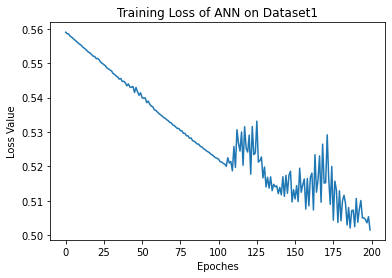

In [1605]:
plt.plot(loss_array)
plt.title("Training Loss of ANN on Dataset1")
plt.xlabel("Epoches")
plt.ylabel("Loss Value")

In [1606]:
model1.eval()
y_pred_first = model1(X_test_first)
y_pred_first_int = []

for item in y_pred_first:
    y_pred_first_int.append(round(float(item[0])))
print(y_pred_first_int)
print(y_test_first)
print(np.sum(y_pred_first_int==np.array(y_test_first))/len(y_pred_first_int))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.])
0.75


In [1607]:
### accuracy on training set
y_pred = model1(X_train_first)
y_pred_int = []

for item in y_pred:
    y_pred_int.append(round(float(item[0])))
print(y_pred_int)
print(y_train_first)
print(np.sum(y_pred_int==np.array(y_train_first))/len(y_pred_int))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
0.7222222222222222


[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


E:\Anaconda\Software\lib\site-packages\ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
E:\Anaconda\Software\lib\site-packages\ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
E:\Anaconda\Software\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


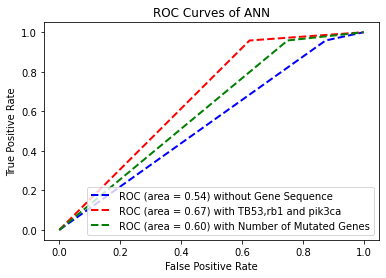

In [1608]:
### ROC and AUC for ANN1

y_label = y_test_first.int().tolist()  # 非二进制需要pos_label
y_pre = y_pred_first_int
print(y_label)
print(y_pre)
fpr1, tpr1, thersholds1 = roc_curve(y_label, y_pre, pos_label=1)
fpr2, tpr2, thersholds2 = roc_curve(y_test_second, y_pred_second_int, pos_label=1)
fpr3, tpr3, thersholds3 = roc_curve(y_test_third, y_pred_third_int, pos_label=1)


 
# for i, value in enumerate(thersholds):
#     print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
 
plt.plot(fpr1, tpr1, 'k--', label='ROC (area = {0:.2f}) without Gene Sequence'.format(roc_auc1), lw=2, color='b')
plt.plot(fpr2, tpr2, 'k--', label='ROC (area = {0:.2f}) with TB53,rb1 and pik3ca'.format(roc_auc2), lw=2, color='r')
plt.plot(fpr3, tpr3, 'k--', label='ROC (area = {0:.2f}) with Number of Mutated Genes'.format(roc_auc3), lw=2, color='g')

 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curves of ANN')
plt.legend(loc="lower right")

### Model for Dataset2

In [1573]:
class Feedforward_second(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward_second, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.batchnorm = torch.nn.BatchNorm1d(self.input_size)
            self.laynorm = torch.nn.LayerNorm(self.input_size)
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size, bias=True)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 5, bias=True)
            self.fc3 = torch.nn.Linear(5, 1, bias=True)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            batchnorm = self.batchnorm(hidden)
            laynorm = self.laynorm(batchnorm)
            relu = self.relu(laynorm)
            output = self.fc2(relu)
            output = self.fc3(output)
            output = self.sigmoid(output)
            return output

In [1574]:
X_train_second

tensor([[ 1., 61.,  2.,  ...,  1.,  1.,  0.],
        [ 2., 46.,  2.,  ...,  1.,  0.,  0.],
        [ 2., 48.,  2.,  ...,  0.,  0.,  0.],
        ...,
        [ 2., 43.,  2.,  ...,  1.,  0.,  0.],
        [ 2., 68.,  2.,  ...,  1.,  0.,  0.],
        [ 2., 55.,  2.,  ...,  0.,  0.,  1.]])

In [1575]:
model2 = Feedforward_second(X_train_second.shape[1],15)
criterion2 = torch.nn.BCELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.01, weight_decay= 0.001)

In [1576]:
model2.train()
epoch = 200
loss_array = []
for epoch in range(epoch):
    optimizer2.zero_grad()
    # Forward pass
    y_pred = model2(X_train_second)
    # Compute Loss
    loss = criterion2(y_pred.squeeze(), y_train_second)
    loss_array.append(float(loss.item()))
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer2.step()

Epoch 0: train loss: 0.6052454710006714
Epoch 1: train loss: 0.5969358086585999
Epoch 2: train loss: 0.5904589891433716
Epoch 3: train loss: 0.584665060043335
Epoch 4: train loss: 0.579624354839325
Epoch 5: train loss: 0.572795033454895
Epoch 6: train loss: 0.5640113949775696
Epoch 7: train loss: 0.5548313856124878
Epoch 8: train loss: 0.5458484292030334
Epoch 9: train loss: 0.5364435315132141
Epoch 10: train loss: 0.5238454937934875
Epoch 11: train loss: 0.5097098350524902
Epoch 12: train loss: 0.4956801235675812
Epoch 13: train loss: 0.48102617263793945
Epoch 14: train loss: 0.4656539559364319
Epoch 15: train loss: 0.4511193335056305
Epoch 16: train loss: 0.4363560974597931
Epoch 17: train loss: 0.42070847749710083
Epoch 18: train loss: 0.4050501585006714
Epoch 19: train loss: 0.3906722068786621
Epoch 20: train loss: 0.3784583508968353
Epoch 21: train loss: 0.368916392326355
Epoch 22: train loss: 0.3594647943973541
Epoch 23: train loss: 0.3484821021556854
Epoch 24: train loss: 0.3394

In [1577]:
torch.save(model2, "ann_model.pt")

Text(0, 0.5, 'Loss Value')

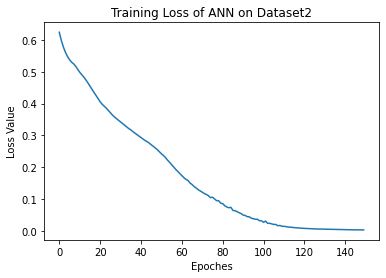

In [1603]:
plt.plot(loss_array)
plt.title("Training Loss of ANN on Dataset2")
plt.xlabel("Epoches")
plt.ylabel("Loss Value")

In [1579]:
model2.eval()
y_pred_second = model2(X_test_second)
y_pred_second_int = []

for item in y_pred_second:
    y_pred_second_int.append(round(float(item[0])))
print(y_pred_second_int)
print(y_test_second)
print(np.sum(y_pred_second_int==np.array(y_test_second))/len(y_test_second))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.])
0.8125


In [1580]:
### accuracy on training set
y_pred = model2(X_train_second)
y_pred_int = []

for item in y_pred:
    y_pred_int.append(round(float(item[0])))
print(y_pred_int)
print(y_train_second)
print(np.sum(y_pred_int==np.array(y_train_second))/len(y_pred_int))

[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
1.0


### Model for Dataset3

In [1611]:
class Feedforward_third(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward_third, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
            self.laynorm = torch.nn.LayerNorm(self.input_size)
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size, bias=True)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 5, bias=True)
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(5, 1, bias=True)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            batchnorm = self.batchnorm(hidden)
            laynorm = self.laynorm(batchnorm)
            relu = self.relu(laynorm)
            output = self.fc2(relu)
            self.relu2 = torch.nn.ReLU()
            output = self.fc3(output)
            output = self.sigmoid(output)
            return output

In [1612]:
model3 = Feedforward_third(X_train_third.shape[1],13)
criterion3 = torch.nn.BCELoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 0.01, weight_decay= 0.001)

In [1613]:
model3.train()
epoch = 150
loss_array = []
for epoch in range(epoch):
    optimizer3.zero_grad()
    # Forward pass
    y_pred = model3(X_train_third)
    # Compute Loss
    loss = criterion3(y_pred.squeeze(), y_train_third)
    loss_array.append(float(loss.item()))
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer3.step()

Epoch 0: train loss: 0.7449527382850647
Epoch 1: train loss: 0.717972457408905
Epoch 2: train loss: 0.6911874413490295
Epoch 3: train loss: 0.665411114692688
Epoch 4: train loss: 0.6416490077972412
Epoch 5: train loss: 0.6199914813041687
Epoch 6: train loss: 0.5994950532913208
Epoch 7: train loss: 0.581000030040741
Epoch 8: train loss: 0.5656672120094299
Epoch 9: train loss: 0.5535496473312378
Epoch 10: train loss: 0.5445176362991333
Epoch 11: train loss: 0.5373896956443787
Epoch 12: train loss: 0.5313980579376221
Epoch 13: train loss: 0.5265540480613708
Epoch 14: train loss: 0.5214558839797974
Epoch 15: train loss: 0.5146776437759399
Epoch 16: train loss: 0.5056299567222595
Epoch 17: train loss: 0.4951423406600952
Epoch 18: train loss: 0.4828510582447052
Epoch 19: train loss: 0.47148430347442627
Epoch 20: train loss: 0.46113377809524536
Epoch 21: train loss: 0.4507763683795929
Epoch 22: train loss: 0.4409792125225067
Epoch 23: train loss: 0.4321078658103943
Epoch 24: train loss: 0.423

Text(0, 0.5, 'Loss Value')

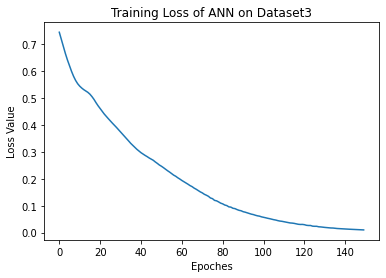

In [1614]:
plt.plot(loss_array)
plt.title("Training Loss of ANN on Dataset3")
plt.xlabel("Epoches")
plt.ylabel("Loss Value")

In [1593]:
model3.eval()
y_pred = model3(X_test_third)
y_pred_third_int = []

for item in y_pred:
    y_pred_third_int.append(round(float(item[0])))
    
print(len(y_pred_third_int))
print(len(y_test_third))
y_test_third = np.array(y_test_third)
print(np.sum(y_pred_third_int==y_test_third)/len(y_pred_third_int))

32
32
0.78125


In [1594]:
### accuracy on training set
y_pred = model3(X_train_third)
y_pred_int = []

for item in y_pred:
    y_pred_int.append(round(float(item[0])))
print(y_pred_int)
print(y_train_third)
print(np.sum(y_pred_int==np.array(y_train_third))/len(y_pred_int))

[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
1.0
